#### If you haven't looked at MostSynapsesInAndOut first, consider starting there, as this notebook builds on concepts described there.

In [1]:
from jupyter_dash import JupyterDash
import dash
import pandas as pd
from nglui.statebuilder import *
from dashdataframe import configure_app
import numpy as np
import matplotlib.pyplot as plt

In [6]:
JupyterDash.infer_jupyter_proxy_config()

read in the soma subgraph synapse table

In [9]:
soma_subgraph_df = pd.read_csv('../data/soma_subgraph_synapses_spines_v185.csv')

we need the position in voxel in a single column
to make nglui work correctly

In [10]:
soma_subgraph_df.loc[:, 'ctr_pos']=soma_subgraph_df.apply(lambda x: [x.ctr_pos_x_vx, x.ctr_pos_y_vx, x.ctr_pos_z_vx], axis=1).copy()


setup a nglui pipeline to visualize synapses

get sources from the neuroglancer link
use nglui (www.github.com/seung-lab/NeuroglancerAnnotationUI) to setup a dataframe > neuroglancer link pipeline


In [11]:

img_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://gs://microns_public_datasets/pinky100_v185/seg"

img_layer = ImageLayerConfig(name='layer23',
                             source=img_source,
                             )
# we want the segmentation layer with our target neuron always on
seg_layer = SegmentationLayerConfig(name = 'seg',
                                    source = seg_source)

# need to consolidate the synapse position into a single column

# setup a mapping rule for point annotations
# in this case this is setup to light up pre and post partner
syn_points = PointMapper(point_column='ctr_pos',
                         set_position=True,
                         linked_segmentation_column=['pre_root_id', 'post_root_id'])

# add these points linked to the segmentation layer name
syn_layer = AnnotationLayerConfig(name='synapses',
                                  mapping_rules=syn_points,
                                  linked_segmentation_layer='seg')
# setup a state builder with this layer pipeline
sb = StateBuilder([img_layer, seg_layer, syn_layer])

The below cell will launch a dash app window within jupyterlab that will look like this.

![alt text](img/dash_screenshot.png "Dash Screenshot")

On the left hand side, you have drop down menus that allow you to choose which variables to plot on the x and y axis, and optionally if you wish to color the dots with respect to a third variable.  

In the middle of the plot you have your scatter plot, and if you mouse over you should see the plotly selection tools, including the lasso tool.

When you select a group of points in the scatter plot, you can do two things:

First, the link at the bottom of the plot labelled "ngl synapse link" will dynamically change on every selection to create a neuroglancer link with those synapses you selected as point annotations in the 'synapse' layer. When you enable the "bracket shortcuts show segmentation" option within the synapse layer options in neuroglancer, and use the bracket keys to iterate through the synapses, the two neurons involved in that synapse will be automatically selected.  This is similar to the MostSynapsesInAndOut notebook.. see that notebook for more explanation.

Second, if you choose you can click the "Filter sort" button the left hand side.  This will remove all the scatter points that were not selected from the plot.  You can then change the axis, or coloring, and only those points will remain plotted in the new view.  This can be useful to computational sort through the data points you are interested in, and iteratively seperate things based upon whatever criteria you are interested in. You can also just leave those points selected and change the axis, and those points will remain highlighted in red in the new view. 

The nglui pipeline constructed above and the visualize_synapses function, is responsible for making this link happen, so you can experiment with modifying the pipeline to alter what neurons are shown, where the annotation are.  Also most of these tools are not actually specific to this dataset, so you might find them useful in other contexts.  There are also more features of [DashDataFrame](https://www.github.com/AllenInstitute/DashDataFrame) and [nglui](https://www.github.com/seung-lab/NeuroglancerAnnotationUI) that are not being used in this context, that you might want to check out or contribute to.




We need to define this simple function to take a set of points which are selected in the UI, passed as selected row ids,
and the dataframe and returns a link for the users.


In [12]:
def visualize_synapses( selected_ids, df):
    dff=df.loc[selected_ids]
    return sb.render_state(dff, return_as='url')

Only some of the columns make sense to scatter plot.  The configure_app functions configures the app to display this dataframe with only some of the columsn, and utilizing the visualize_synapse function to create the dynamically updated link. 

In [14]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

configure_app(app, soma_subgraph_df,
              link_func=visualize_synapses, link_name='ngl synapse link',
              plot_columns = ['cleft_vx', 'spine_vol_um3', 'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm'])

app.run_server('external',port=8555)

Dash app running on http://localhost:8888/proxy/8555/


As a side note.  If you are running a notebook, or on a local computer, you can use the alternative 
of simply running 
```
app.run_server(port=XXXX)
```
and avoiding needing jupyterlab_dash, but to make this work on MyBinder we had to use this.

# Multi Synapse Connections
Now lets do some analysis that reproduces some results from Dorkenwald et al. 2019

https://www.biorxiv.org/content/10.1101/2019.12.29.890319v1

but now in a dynamic plot

The paper displays data in log volume units

In [15]:
soma_subgraph_df['log_spine_vol_um3']=np.log10(soma_subgraph_df.spine_vol_um3)
soma_subgraph_df['log_cleft_vx']=np.log(soma_subgraph_df.cleft_vx)

group by connection

In [16]:
conn_grouped=soma_subgraph_df.groupby(['pre_root_id', 'post_root_id'])

average size of synapses in connection (both log first and straight)
transform will save it back to each synapse (so the info is repeated for every synapse in a connection)


In [17]:
mean_size_df=conn_grouped[['cleft_vx','log_spine_vol_um3','log_cleft_vx', 'spine_vol_um3']].transform('mean')

let's rename the columns

In [18]:
mean_size_df.columns=['mean_cleft_vx', 
                      'mean_log_spine_vol_um3', 
                      'mean_log_cleft_vx',
                      'mean_spine_vol_um3']

how many total synapses are involved with this synapse connection
again transform to repeat it for every synapse

In [19]:
count_df = conn_grouped['cleft_vx'].transform('count')

Lets rename the column

In [20]:
count_df.name='num_syn_in_conn'

In [21]:
mean_size_df

,mean_cleft_vx,mean_log_spine_vol_um3,mean_log_cleft_vx,mean_spine_vol_um3
0,798.000000,-0.876135,6.682109,0.133004
1,209.000000,-1.056534,5.342334,0.087794
2,589.666667,-0.897432,6.238515,0.140721
3,589.666667,-0.897432,6.238515,0.140721
4,589.666667,-0.897432,6.238515,0.140721
...,...,...,...,...
1956,74.000000,-1.600121,4.304065,0.025112
1957,211.000000,-1.524232,5.351858,0.029907
1958,134.000000,-1.220009,4.897840,0.060255
1959,95.000000,-1.831054,4.553877,0.014755


Make a new dataframe that appends these new columns to the original


In [22]:
new_df = pd.concat([soma_subgraph_df, mean_size_df, count_df], axis=1)

This is a histogram of log10(um^3) spine head volumes
for all synapses involved in a 2 synapse connection in the dataset

Text(0.5, 1.0, 'see Figure 3d')

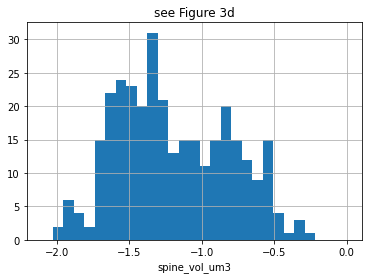

In [23]:
f, ax = plt.subplots()
new_df.query('num_syn_in_conn==2').log_spine_vol_um3.hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('spine_vol_um3')
ax.set_title('see Figure 3d')

this is now the average log10(um^3) spine head volume for 
synapses in 2 synapse connections.
Note how the bimodality is MORE pronounced here than
it was in the histogram of individual sizes

Text(0.5, 1.0, 'see Figure 3e')

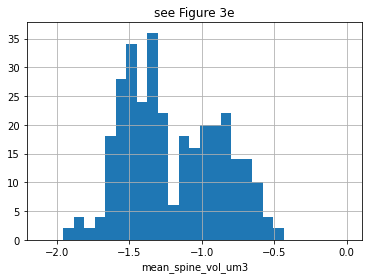

In [24]:
f, ax = plt.subplots()
new_df.query('num_syn_in_conn==2').mean_log_spine_vol_um3.hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('mean_spine_vol_um3')
ax.set_title('see Figure 3e')

In [25]:
# pick out the columns that are relevant in this dataframe
selected_columns = [ 'num_syn_in_conn', 'mean_spine_vol_um3', 'cleft_vx', 'spine_vol_um3',
       'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm', 'log_spine_vol_um3', 'log_cleft_vx',
       'mean_cleft_vx', 'mean_log_spine_vol_um3', 'mean_log_cleft_vx']

Below you can use this dash app to explore this dataset, and select synapses based upon
their aggregate connection properties
as well as their individual properties.

You can select synapses involved in dual or more than dual connections
and then hit filter on the left to only show those points.

Then you can dive into other metrics by changing the x,y axis on the scatter plot.
The link will keep updating to include annotation points for the synapses you select.

In [28]:
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
configure_app(app, new_df,
              link_func=visualize_synapses, link_name='ngl synapse link',
              plot_columns = selected_columns)

app.run_server(mode='external',port=8556)

Dash app running on http://localhost:8888/proxy/8556/


Now if we want to reproduce Figure 4, we need to create a slightly different dataframe, where each row represents a pair of synapses in a dual synapse connection.

first lets just filter our dataframe for dual synapse connections.


In [29]:
dual_syn = new_df.query('num_syn_in_conn==2')

In [30]:
# a list of dictionaries to create our new dataframe
ds = []
for pair, grp in dual_syn.groupby(['pre_root_id', 'post_root_id']):
    # sort them by log spine volume
    grp = grp.sort_values('log_spine_vol_um3')
    d={
        'pre_root_id': pair[0],
        'post_root_id': pair[1],
        'pos_1': grp.iloc[0].ctr_pos,
        'pos_2': grp.iloc[1].ctr_pos,
        'log_spine_vol_um3_1': grp.iloc[0].log_spine_vol_um3,
        'log_spine_vol_um3_2': grp.iloc[1].log_spine_vol_um3,
        'mean_log_spine_vol_um3': grp.iloc[0].mean_log_spine_vol_um3,
        'mean_cleft_vx': grp.iloc[0].mean_cleft_vx,
        'log_cleft_vx_1': grp.iloc[0].log_cleft_vx,
        'log_cleft_vx_2': grp.iloc[1].log_cleft_vx,
        'syn_id_1': grp.iloc[0].id,
        'syn_id_2': grp.iloc[1].id    
    }
    ds.append(d)
dual_syn_df = pd.DataFrame(ds)

In [31]:
dual_syn_df.head()

,pre_root_id,post_root_id,pos_1,pos_2,log_spine_vol_um3_1,log_spine_vol_um3_2,mean_log_spine_vol_um3,mean_cleft_vx,log_cleft_vx_1,log_cleft_vx_2,syn_id_1,syn_id_2
0,648518346349492682,648518346349537515,"[104535.0, 56803.0, 1235.0]","[108636.0, 70893.0, 1492.0]",-1.359268,-0.523567,-0.941417,874.0,4.499810,7.413367,2988623,3271025
1,648518346349519354,648518346349531327,"[96742.0, 57122.0, 1502.0]","[97537.0, 39435.0, 1261.0]",-1.002666,-0.567721,-0.785193,645.0,6.200509,6.680855,2313123,2573660
2,648518346349519354,648518346349532295,"[97454.0, 44494.0, 1420.0]","[82508.0, 51156.0, 1037.0]",-1.629881,-1.197137,-1.413509,105.0,4.234107,4.948760,100426,871661
3,648518346349519354,648518346349538235,"[84348.0, 52976.0, 1299.0]","[83062.0, 51416.0, 1072.0]",-0.939439,-0.574285,-0.756862,721.0,6.646391,6.510258,2579251,2509483
4,648518346349523975,648518346349537514,"[68668.0, 50266.0, 173.0]","[68216.0, 49464.0, 178.0]",-1.534128,-1.513598,-1.523863,107.5,4.574711,4.770685,421994,3251557


In [32]:
dual_syn_df.columns

Index(['pre_root_id', 'post_root_id', 'pos_1', 'pos_2', 'log_spine_vol_um3_1',
       'log_spine_vol_um3_2', 'mean_log_spine_vol_um3', 'mean_cleft_vx',
       'log_cleft_vx_1', 'log_cleft_vx_2', 'syn_id_1', 'syn_id_2'],
      dtype='object')

let's make a new nglui in order to highlight each synapse pair as a line
rather than individual points

we can reuse our synapse and segmentation layers

setup a mapping rule for Line annotations
in this case this is setup to light up pre and post partner
and connect both synapses in a connection with a line.

In [33]:
syn_line_mapper = LineMapper(point_column_a='pos_1', point_column_b='pos_2',
                       linked_segmentation_column=['pre_root_id', 'post_root_id'])

# add these lines linked to the segmentation layer name
dual_syn_layer = AnnotationLayerConfig(name='dual synapses', mapping_rules=syn_line_mapper, linked_segmentation_layer='seg')
# setup a state builder with this layer pipeline
dual_sb = StateBuilder([img_layer, seg_layer, dual_syn_layer])

We will need just a slightly different link generating function


In [34]:
def visualize_dual_synapses( selected_ids, df):
    dff=df.loc[selected_ids]
    return dual_sb.render_state(dff, return_as='url')

We set the plot columns here to only show the ones that make sense to plot
and to make the default first two columns be the ones shown in Figure 4a
note that we haven't mirrored the data points as was done in the Figure.

In [36]:
dual_app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

configure_app(dual_app, dual_syn_df,
              link_func=visualize_dual_synapses, link_name='ngl synapse link',
              plot_columns = 
              ['log_spine_vol_um3_1', 'log_spine_vol_um3_2', 'mean_log_spine_vol_um3', 'mean_cleft_vx',
                'log_cleft_vx_1', 'log_cleft_vx_2', 'pre_root_id', 'post_root_id'])

dual_app.run_server(mode='external',port=8557)

Dash app running on http://localhost:8888/proxy/8557/


Exception in thread Thread-87:
Traceback (most recent call last):
  File "/Users/sharmishtaas/anaconda3/envs/ofs/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/Users/sharmishtaas/anaconda3/envs/ofs/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/sharmishtaas/anaconda3/envs/ofs/lib/python3.7/site-packages/retrying.py", line 49, in wrapped_f
    return Retrying(*dargs, **dkw).call(f, *args, **kw)
  File "/Users/sharmishtaas/anaconda3/envs/ofs/lib/python3.7/site-packages/retrying.py", line 212, in call
    raise attempt.get()
  File "/Users/sharmishtaas/anaconda3/envs/ofs/lib/python3.7/site-packages/retrying.py", line 247, in get
    six.reraise(self.value[0], self.value[1], self.value[2])
  File "/Users/sharmishtaas/anaconda3/envs/ofs/lib/python3.7/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/sharmishtaas/anaconda3/envs/ofs/lib/python3.7/site-packages/retrying.py",

A suggested exercise to explore the data further is to figure out how to extend this code to add pairs of synapses in 3, 4 and 5 synapse connections to this dynamic scatter plot. 